In [2]:

import numpy as np
import matplotlib.pyplot as plt
import copy
import gym
get_ipython().run_line_magic('matplotlib', 'inline')


In [3]:
# Creation of the environment

env = gym.make("Taxi-v3", render_mode="human")


In [4]:
env.reset()
env.render()

In [5]:
env.action_space.n

env.observation_space.n

500

In [6]:
print(env.step(1))

(251, -1, False, False, {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)})


c:\Users\pablo\anaconda3\envs\RL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [10]:
env.render()

In [11]:
env.close()

In [12]:
# Creation of the environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [13]:
def double_q_learning(env, gamma=0.9, alpha=0.01, eps=0.05, num_episodes=1000):
    
    # Initialize Q-table
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = Q1.copy()
    rewards = np.zeros(num_episodes)
    ep = 0
    while ep < num_episodes:
        s_0 = env.reset()
        s_0 = s_0[0]
        done = False
        while done == False:
            if np.random.rand() < eps:
                action = env.action_space.sample()
            else:
                q_sum = Q1[s_0] + Q2[s_0]
                max_qs = np.where(np.max(q_sum)==q_sum)[0]
                action = np.random.choice(max_qs)

            s_1, r, done, t, _ = env.step(action)
            # Flip a coin to update Q1 or Q2
            if np.random.rand() < 0.5:
                Q1[s_0, action] += alpha*(r + 
                    gamma*Q2[s_1, np.argmax(Q1[s_1])] - Q1[s_0, action])
            else:
                Q2[s_0, action] += alpha*(r + 
                    gamma*Q1[s_1, np.argmax(Q2[s_1])] - Q2[s_0, action])
            rewards[ep] += r
            s_0 = s_1
            if done:
                ep += 1
    return rewards, Q1, Q2


In [14]:
def q_learning(env, gamma=0.9, alpha=0.01, eps=0.05, num_episodes=1000):
    
    # Initialize Q-table
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = np.zeros(num_episodes)
    ep = 0
    while ep < num_episodes:
        s_0 = env.reset()
        s_0= s_0[0]
        
        done = False
        while done == False:
            if np.random.rand() < eps:
                action = env.action_space.sample()
            else:
                max_qs = np.where(np.max(Q[s_0])==Q[s_0])[0]
                action = np.random.choice(max_qs)

            s_1, r, done, t, _ = env.step(action)
            Q[s_0, action] += alpha*(r + gamma*np.max(Q[s_1]) - Q[s_0, action])
            rewards[ep] += r
            s_0 = s_1
            if done:
                ep += 1
    return rewards, Q


In [15]:
dq_rewards, Q1, Q2 = double_q_learning(env, num_episodes=10000, alpha=0.1)
q_rewards, Q = q_learning(env, num_episodes=10000, alpha=0.1)
window = 10
dq_avg_rewards = np.array([np.mean(dq_rewards[i-window:i])  
                           if i >= window
                           else np.mean(dq_rewards[:i])
                           for i in range(1, len(dq_rewards))
                          ])
q_avg_rewards = np.array([np.mean(q_rewards[i-window:i])  
                          if i >= window
                          else np.mean(q_rewards[:i])
                          for i in range(1, len(q_rewards))
                         ])



In [16]:
env.close()

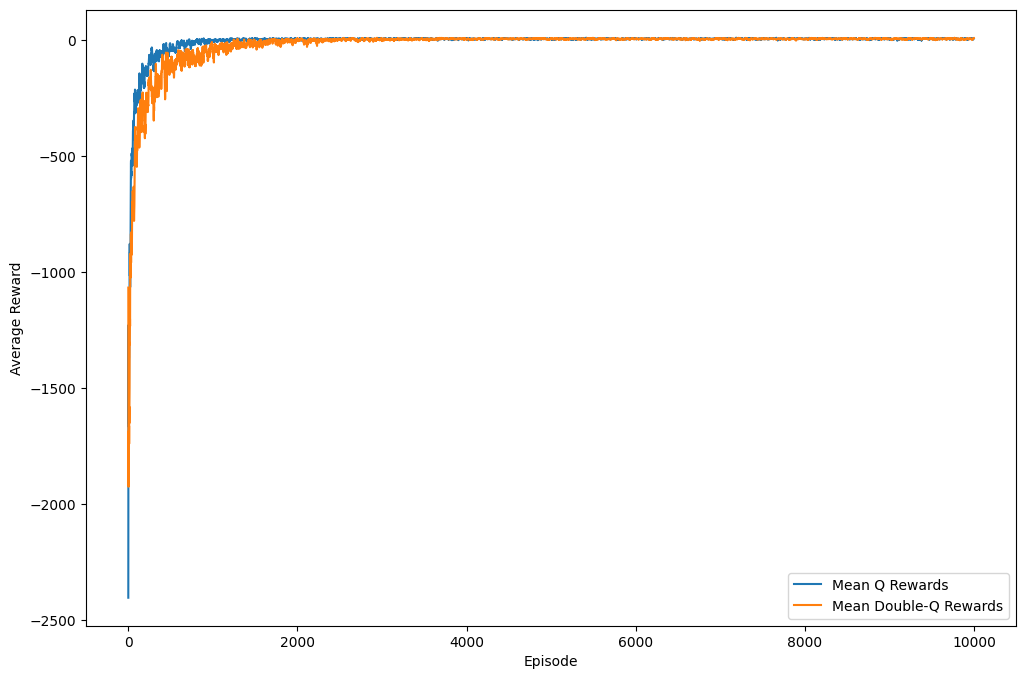

In [17]:
plt.figure(figsize=(12,8))
plt.plot(q_avg_rewards, label='Mean Q Rewards')
plt.plot(dq_avg_rewards, label='Mean Double-Q Rewards')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.show()


In [18]:
tail_length = 1000
print("Mean Q-Learning Rewards: \t{:.2f}\nMean Double Q-Learning Rewards: {:.2f}".format(
    q_avg_rewards[-tail_length:].mean(), dq_avg_rewards[-tail_length:].mean()))
print("Percentage Difference:\t\t{:.2f}%".format(
    (dq_avg_rewards[-tail_length:].mean()/q_avg_rewards[-tail_length:].mean() - 1)
    * 100))


Mean Q-Learning Rewards: 	5.25
Mean Double Q-Learning Rewards: 5.34
Percentage Difference:		1.81%


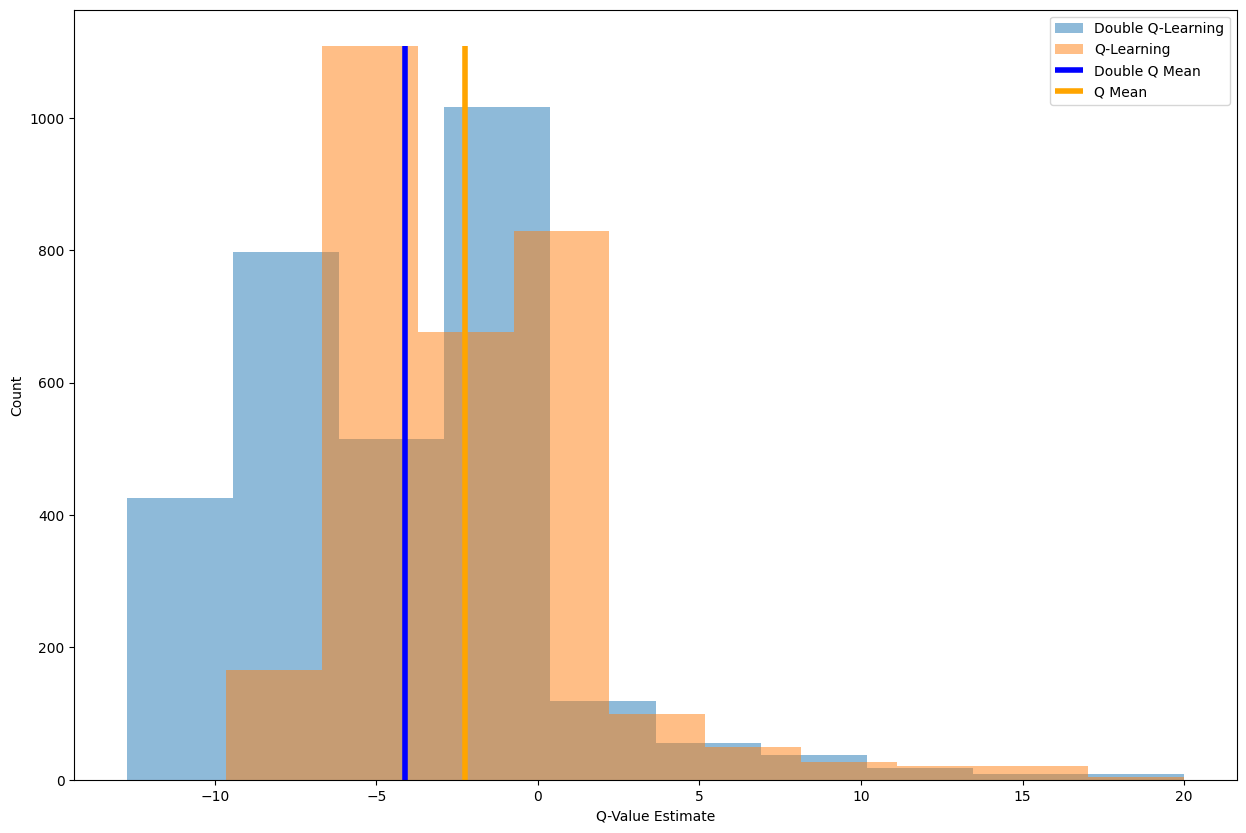

In [19]:

plt.figure(figsize=(15,10))
DQ_final_table = (Q1 + Q2) / 2
ax_dq = plt.hist(DQ_final_table.ravel(), label='Double Q-Learning', alpha=0.5)
ax_q = plt.hist(Q.ravel(), label='Q-Learning', alpha=0.5)
vline_height = np.max(np.hstack([ax_dq[0], ax_q[0]]))
plt.vlines(x=DQ_final_table.mean(), ymin=0, ymax=vline_height, 
           label='Double Q Mean', color='b', linewidth=4)
plt.vlines(x=Q.mean(), ymin=0, ymax=vline_height, 
           label='Q Mean', color='orange', linewidth=4)
plt.legend()
plt.xlabel('Q-Value Estimate')
plt.ylabel('Count')
plt.show()


In [20]:
env.close()

In [21]:
# Creation of the environment
env = gym.make("Taxi-v3", render_mode="human")

In [22]:
q_table= Q2

In [23]:
# After 10 000 episodes, our Q-table can be used as a "cheatsheet" to play FrozenLake"
# Here the agent plays FrozenLake

env.reset()

max_steps = 100

for episode in range(10):
    state = env.reset()
    state=state[0]
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(q_table[state,:])
        
        new_state, reward, done, truncate, info = env.step(action)

        env.render()
        
        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            env.render()
            
            # We print the number of step it took.
            print("Number of steps", step)
            break
        state = new_state
env.close()

****************************************************
EPISODE  0
Number of steps 10
****************************************************
EPISODE  1
Number of steps 9
****************************************************
EPISODE  2
Number of steps 9
****************************************************
EPISODE  3
Number of steps 13
****************************************************
EPISODE  4
Number of steps 11
****************************************************
EPISODE  5
Number of steps 11
****************************************************
EPISODE  6
Number of steps 13
****************************************************
EPISODE  7
Number of steps 11
****************************************************
EPISODE  8
Number of steps 14
****************************************************
EPISODE  9
Number of steps 15


In [ ]:
env.close()